In [1]:
%load_ext autoreload
%autoreload 2

# hardware
import os
# analysis
import numpy as np
import xarray as xr
import pandas as pd
from scipy.integrate import simps
from scipy.interpolate import RegularGridInterpolator
# vis
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-deep')

# Acoustic tomography package
import atom
# configuration object
from hydra import initialize, compose
from hydra.utils import instantiate
with initialize(version_base=None, config_path="../../conf/"):
    cfg = compose(config_name="configs",)

# Acoustic tomography array object
- instatiate from configuration object
- calculates path info (length, orientation, unit vector) internally
- path integral information setup for later use
- plot speaker and microphone locations
- plot acoustic travel paths

In [2]:
### Array data
atarray = instantiate(cfg.atarray)
atarray.setupPathIntegrals()

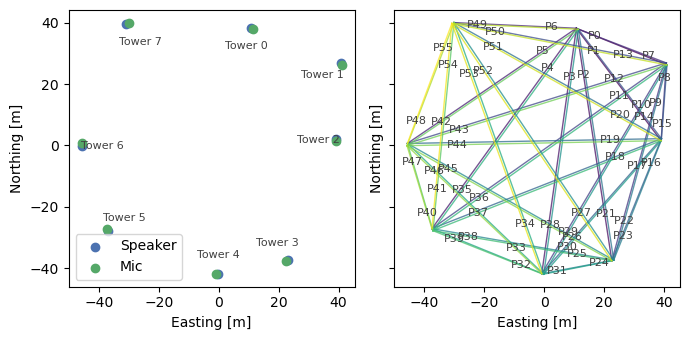

In [3]:
fig, ax = plt.subplots(1,2, figsize=(7,3.5), sharex=True, sharey=True)

ax[0] = atarray.plotSpkMicLocations(ax=ax[0])

c = plt.cm.viridis(np.linspace(0, 1, len(atarray.ds.pathID)))
ax[1] = atarray.plotPaths(ax=ax[1], c=c)

fig.tight_layout()

# Auxiliary data object
- instatiate from configuration object
- plot time series
- calculate and plot spectra with Welch's method
- calculate and plot autocorrelation coefficient
- estimate integral time and length scales (Taylor's hypothesis)

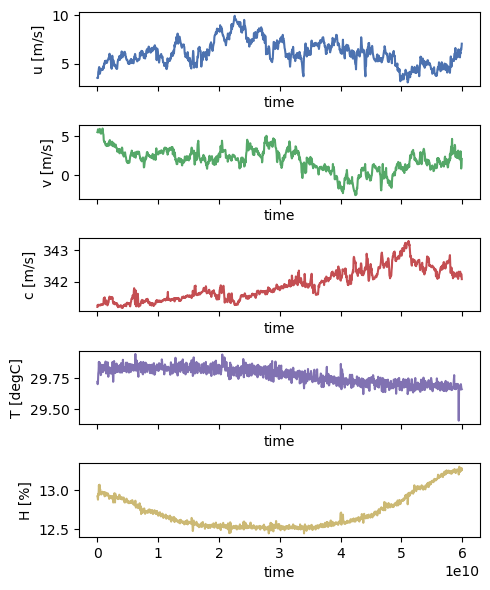

In [4]:
### Auxiliary data
auxdata = instantiate(cfg.auxdata)
auxDataPath = "../AuxData_example.txt"
auxdata.loadData(auxDataPath)


fig, ax = plt.subplots(5,1, figsize=(5, 6), sharex=True)

for ii, var in enumerate(['u','v','c','T','H']):
    auxdata.ds[var].plot(ax=ax[ii], c=f'C{ii}')
fig.tight_layout()

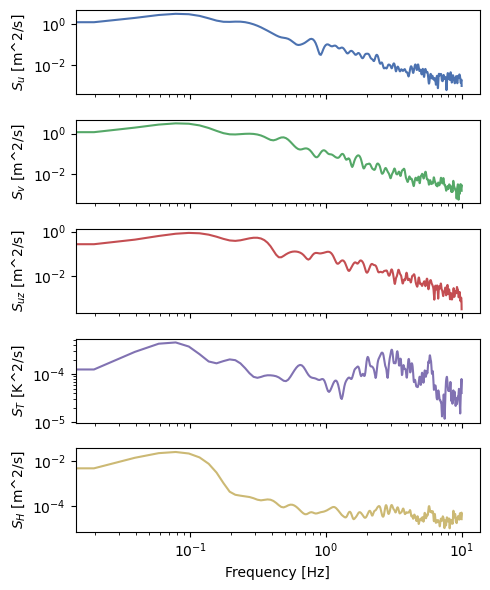

In [5]:
auxdata.calculateSpectra()

fig, ax = plt.subplots(5,1, figsize=(5, 6), sharex=True)

for ii, var in enumerate(['u','v','uz','T','H']):
    ax[ii].loglog(auxdata.ds.frequency, auxdata.ds[f'S_{var}'], c=f'C{ii}')
    ax[ii].set_ylabel(f'$S_{{{var}}}$ [{auxdata.ds[f"S_{var}"].units}]')
ax[-1].set_xlabel('Frequency [Hz]')
fig.tight_layout()


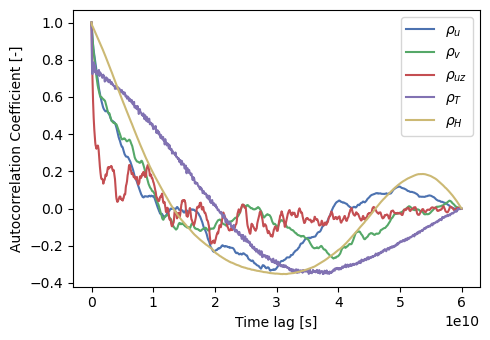

In [6]:
auxdata.autoCorrelation()

fig, ax = plt.subplots(figsize=(5, 3.5))

for ii, var in enumerate(['u','v','uz','T','H']):
    ax.plot(auxdata.ds.time, auxdata.ds[f'rho_{var}'], c=f'C{ii}', label=f'$\\rho_{{{var}}}$')
ax.set_ylabel(f'Autocorrelation Coefficient [-]')
ax.set_xlabel('Time lag [s]')

ax.legend()

fig.tight_layout()


In [7]:
auxdata.integral_scale()
auxdata.ds.attrs

{'samplingFrequency': 20.0,
 'recordTimeDuration': 0.5,
 'recordTimeDelta': 0.05,
 'recordLength': 1200,
 'sonicAnemometerOrientation': 0.0,
 'windowType': 'hann',
 'threshold': 0.5,
 'tau_u': 7.918675695892259,
 'L_u': 48.17162047075365,
 'tau_v': 7.296752778678485,
 'L_v': 13.957173989410366,
 'tau_uz': 4.958264552346053,
 'L_uz': 0.43593888321651886,
 'tau_T': 1.1152540937344828,
 'L_T': 33.19953070966245,
 'tau_H': 12.001672723618048,
 'L_H': 152.64853526854668}

# Audio data object
- instatiate from configuration object
- load data
- isolate reference signal emitted by each speaker
- plot recorded microphone data

In [8]:
### Microphone data
audiodata = instantiate(cfg.audiodata)
mainDataPath = "../MainData_example.txt"
audiodata.loadData(mainDataPath)

In [9]:
audiodata.ds

<xarray.Dataset>
Dimensions:                    (time: 10000, mic: 8, frame: 120, spk: 8)
Coordinates:
  * time                       (time) timedelta64[ns] 00:00:00 ... 00:00:00.4...
  * mic                        (mic) int64 0 1 2 3 4 5 6 7
  * frame                      (frame) int64 0 1 2 3 4 5 ... 115 116 117 118 119
  * spk                        (spk) int64 0 1 2 3 4 5 6 7
Data variables:
    speakerSignalEmissionTime  (spk) float64 0.124 0.104 0.204 ... 0.04 0.144
    micData                    (time, mic, frame) float64 -5.884 ... -9.248
    refSig                     (time) float64 0.0 0.0 0.0 0.0 ... nan nan nan
Attributes:
    description:            Signals recorded by microphones
    samplingFrequency:      20000
    deltaT:                 0.05
    recordTimeDuration:     0.5
    recordTimeDelta:        5e-05
    recordLength:           10000
    nMics:                  8
    nFrames:                120
    chirpCentralFrequency:  1200
    chirpBandwidth:         700
    nSpeakers:              8

Text(0, 0.5, 'Intensity [-]')

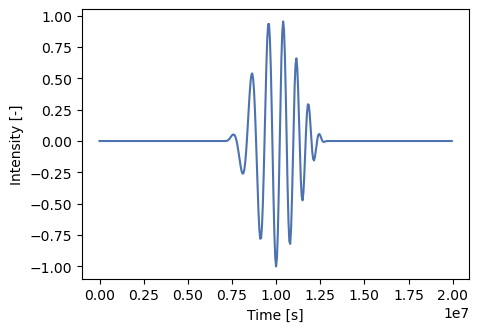

In [10]:
fig, ax = plt.subplots(figsize=(5,3.5))
ax.plot(audiodata.ds.time, audiodata.ds.refSig, label='Reference Signal')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Intensity [-]')

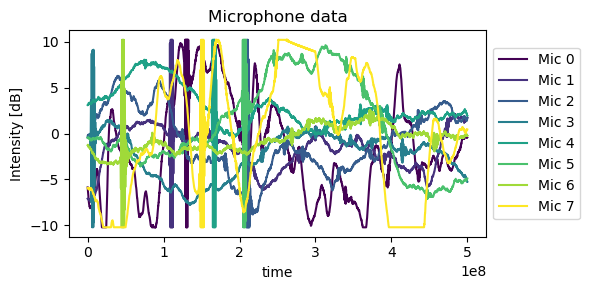

In [11]:
fig,ax = plt.subplots(figsize=(6,3), sharex=True, sharey=True)

c=plt.cm.viridis(np.linspace(0,1,audiodata.ds.nMics))

for ii, mic in enumerate(audiodata.ds.mic):
    audiodata.ds.micData.sel(frame=0, mic=mic).plot(ax=ax, label=f'Mic {ii}', c=c[ii,:])
ax.set_title('Microphone data')
ax.set_ylabel(f'Intensity [dB]')
ax.legend(loc=6, bbox_to_anchor=(1,0.5))
fig.tight_layout()

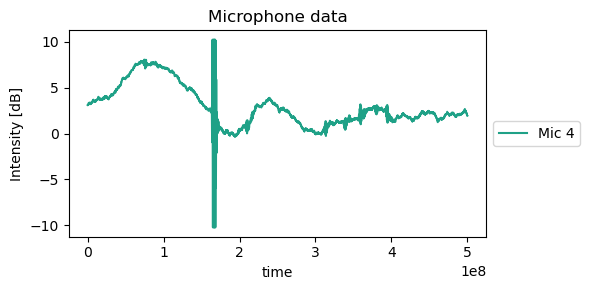

In [12]:
fig,ax = plt.subplots(figsize=(6,3), sharex=True, sharey=True)

c=plt.cm.viridis(np.linspace(0,1,audiodata.ds.nMics))

micNumber = 4
audiodata.ds.micData.sel(frame=0, mic=micNumber).plot(ax=ax, label=f'Mic {micNumber}', c=c[micNumber,:])
ax.set_title('Microphone data')
ax.set_ylabel(f'Intensity [dB]')
ax.legend(loc=6, bbox_to_anchor=(1,0.5))
fig.tight_layout()